ФИО : Яковлев Дмитрий Алексеевич

Прошу прощение за задержку. Из-за вдруг возникших проблем с зубами и очень сильной вследствие этого болью, не смог выполнить и отправить вам задания до дедлайна. Прошу войти в положение, если это конечно возможно. Впредь буду стараться отправлять задания вовремя. Надеюсь на ваше понимание.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [8]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
data_path = "/content/gdrive/My Drive/notebooks/NN/hw1/layers_of_fear/diamonds.csv"

Mounted at /content/gdrive


In [9]:
diamonds_df = pd.read_csv(data_path)

In [10]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


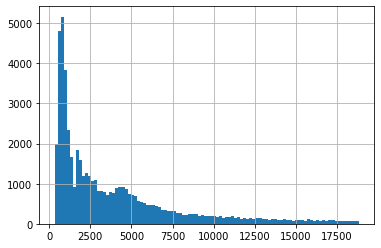

In [11]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid();

# Подготовка данных

In [12]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [13]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [14]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [15]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [16]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

# Обучаем модель линейной регрессии

In [18]:
reg = LinearRegression().fit(X_train, y_train)

In [19]:
y_pred = reg.predict(X_test)

In [20]:
score = r2_score(y_pred, y_test)

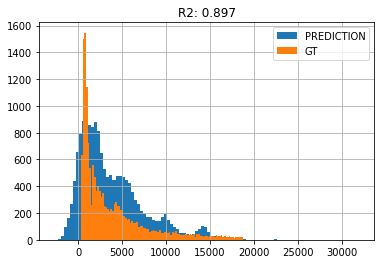

In [21]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

# Создаём модель MLP для задачи регрессии

Делал попытку реализовать через списки матриц весов и градиентов, но сложность пробрасывания градиентов и сложность последующей отладки заставили меня отказаться от данной идеи, хоть и очень хотелось.
<br>
Приключения с матрицами в итоге привели меня к объектной модели. Что ж давайте реализуем класс полносвязного слоя (для инкапсулирования весовой матрицы и смещений), сигмоиды (для введения нелинейнойсти), а также класс функционала качества для текущей задачи регресии.

### Полносвязный слой
Класс полносвязного слоя инкапсулируюшего в себе матрицу весов между двумя слоями нейроной, а также вектор смещений.
<br>
Поддерживает интерфейс: <br>
- forward(self, X, $y_{real}$ )
- backward(self, $dLdy$)
- step(step, self, $learning \ rate$)
- clean(self)

In [22]:
class Dense:
    def __init__(self, in_neurons, out_neurons):
        ''' константа для уменьшение вероятности выпадения чисел |w| > 1
            поскольку большие веса в итоге способны "взорваться"
        '''
        self.in_neurons  = in_neurons
        self.out_neurons = out_neurons

        self.weights = np.random.randn(self.in_neurons, self.out_neurons) * 0.001
        self.biases  = np.zeros(self.out_neurons)

        self.X    = None
        self.dLdx = None
        self.dLdw = None
        self.dLdb = None


    def forward(self, X, y_real=None):
        self.X = X
        return self.X @ self.weights + self.biases


    def backward(self, dLdy):
        self.dLdx = dLdy @ self.weights.T
        self.dLdw = self.X.T @ dLdy
        self.dLdb = np.sum(dLdy, axis=0)

        return self.dLdx

    
    def step(self, learning_rate):
        self.weights -=  (self.dLdw * learning_rate)
        self.biases  -=  (self.dLdb * learning_rate)
    

    def clean(self):
        self.weights = np.random.randn(self.in_neurons, self.out_neurons) * 0.001
        self.biases *= 0
        self.X      *= 0
        self.dLdx   *= 0
        self.dLdw   *= 0
        self.dLdb   *= 0

### Нелинейность. Сигмоида
В качестве нелинейной функции выбрана классическая сигмоида, учитывая то что входящие данные отмасштабированы, и персептрон будет тестироваться на небольшой глубине.<br>
Поддержан интерфейс:
- forward(self, X, $y_{real}$ )
- backward(self, $dLdy$)
- step(step, self, $learning \ rate$)
- clean(self)

In [23]:
class Sigmoid:
    def __init__(self):
        self.sigmoid = None

    
    def forward(self, X, y_real=None):
        self.sigmoid = 1  / ( 1 + np.exp(-X) )
        return self.sigmoid


    def backward(self, dLdy):
        return self.sigmoid * (1 - self.sigmoid) * dLdy

    
    def step(self, learning_rate):
        pass

    
    def clean(self):
        self.sigmoid *= 0

### Функционал качества
Реализованы следующие функции потерь: <br>
$MSE$, $MAE$
Поддержан интерфейс:
- forward(self, X, $y_{real}$ )
- backward(self, $dLdy$)
- step(step, self, $learning \ rate$)
- clean(self)

In [59]:
class Loss:
    def __init__(self, loss_type : str = "MSE"):
        self.loss_type = loss_type
        
        self.L      = None
        self.dLdy   = None
        self.y_pred = None
        self.y_real = None


    def forward(self, y_pred, y_real):
        self.y_pred = y_pred
        self.y_real = y_real

        if self.loss_type == "MSE":
            self.L = np.mean( (self.y_pred - self.y_real)**2 )
        elif self.loss_type == "MAE":
            self.L = np.mean( np.abs(self.y_pred - self.y_real) )

        return self.L

    
    def backward(self, dLdy):
        if self.loss_type == "MSE":
            self.dLdy = (2 / self.y_real.shape[0]) * (self.y_pred - self.y_real)
        elif self.loss_type == "MAE":
            self.dLdy = np.sign(self.y_pred - self.y_real) # (1 / self.y_real.shape[0]) *

        return self.dLdy

    
    def step(self, learning_rate):
        pass

    
    def clean(self):
        self.y_pred *= 0
        self.y_real *= 0

### Батч-генератор
Генератор пакетов/батчей данных.

In [25]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    batch_max_size = y.shape[0]
    if shuffle:
        idx = np.arange(batch_max_size)
        np.random.shuffle(idx)
        shuffled_X = X[idx]
        shuffled_y = y[idx]
        
    batch_count = int(np.ceil(batch_max_size / batch_size))
    for i in range(batch_count):
        begin = i*batch_size
        end = batch_max_size if (i+1)*batch_size > batch_max_size else (i+1)*batch_size
        
        if shuffle:
            X_batch = shuffled_X[begin : end]
            y_batch = shuffled_y[begin : end]
        else:
            X_batch = X[begin : end]
            y_batch = y[begin : end]
                
        yield (X_batch, y_batch)

### Многослойный персептрон
Поддерживает классический sklearn интерфейс:
- fit(self, $X_{train}$, $y_{train}$)
- predict(self, $X_{test}$)

От базового sklearn класса не наследовался, поэтому $sklearn.model{\_}selection.cross{\_}val$ работать не будет.

In [91]:
class MLPRegressor:
    def __init__(
        self,
        hidden_layer_sizes=(100,),
        learning_rate=1e-6,
        max_iter=10,
        loss_type = "MSE",
        re_fit = True,
        early_stop = False,
    ):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.loss_type = loss_type
        self.re_fit = re_fit

        self.layers    = []
        self.x_shape_1 = 0
        self.y_shape_1 = 0

        self.epoch_train_loss = []
        self.epoch_val_loss   = []

        self.early_stop = early_stop
        self.early_stop_delta = 0.01 if self.loss_type == "MAE" else 10;

    
    def fit(self, X, y):
        if X.shape[1] != self.x_shape_1 or y.shape[1] != self.y_shape_1:
            self.x_shape_1 = X.shape[1]
            self.y_shape_1 = y.shape[1]

            in_neurons = self.x_shape_1
            for out_neurons in self.hidden_layer_sizes:
                self.layers.extend(
                [
                    Dense(in_neurons, out_neurons),
                    Sigmoid(),
                ]
                )
                in_neurons = out_neurons

            self.layers.extend(
            [
                Dense(in_neurons, self.y_shape_1),
                Loss(self.loss_type),
            ]
            )
        elif self.re_fit:
            for layer in self.layers:
                layer.clean()

        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

        iter, is_train_loss_changing, is_val_loss_changing = 0, True, True
        while (
            iter < self.max_iter and
            is_train_loss_changing and
            is_val_loss_changing 
        ):
            cur_epoch_train_loss, cur_epoch_val_loss = [], -1
            for X_batch, y_batch in batch_generator(X_train, y_train, shuffle=True, batch_size=64):
                # forwarding

                result = X_batch
                for layer in self.layers:
                    result = layer.forward(result, y_batch)

                cur_epoch_train_loss.append(result)
                # backwarding

                dLdy = None
                for layer in reversed(self.layers):
                    dLdy = layer.backward(dLdy)

                # apply gradients

                for layer in self.layers:
                    layer.step(self.learning_rate)
                

            # make validation
            result_val = X_val
            for layer in self.layers:
                result_val = layer.forward(result_val, y_val)
            
            cur_epoch_val_loss = result_val
            self.epoch_train_loss.append(np.mean(cur_epoch_train_loss))
            self.epoch_val_loss.append(cur_epoch_val_loss)

            if self.early_stop and len(self.epoch_train_loss) > 10:
                if np.abs(self.epoch_train_loss[iter] - self.epoch_train_loss[iter-1]) < self.early_stop_delta:
                    is_train_loss_changing = False
                elif np.abs(self.epoch_val_loss[iter] - self.epoch_val_loss[iter-1]) < self.early_stop_delta:
                    is_train_loss_changing = False
            
            iter += 1
                
    
    def predict(self, X):
        result = X
        for layer in self.layers[:-1]:
            result = layer.forward(result, y_train)

        return result

# Проверяем модель MLP на выборке Diamonds

### Тестовый прогон

In [34]:
'''
Тестовый прогон, для отладки с MSE
'''

mymodel = MLPRegressor(
    hidden_layer_sizes=(100,), 
    max_iter=1000, 
    learning_rate=1e-6
)
mymodel.fit(X_train, y_train)

In [68]:
y_pred = mymodel.predict(X_test)
score = r2_score(y_pred, y_test)
score

0.9660132439353055

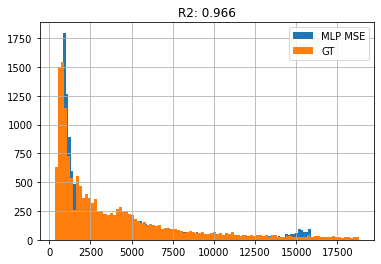

In [70]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='MLP MSE')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')

plt.legend()
plt.grid()
plt.show()

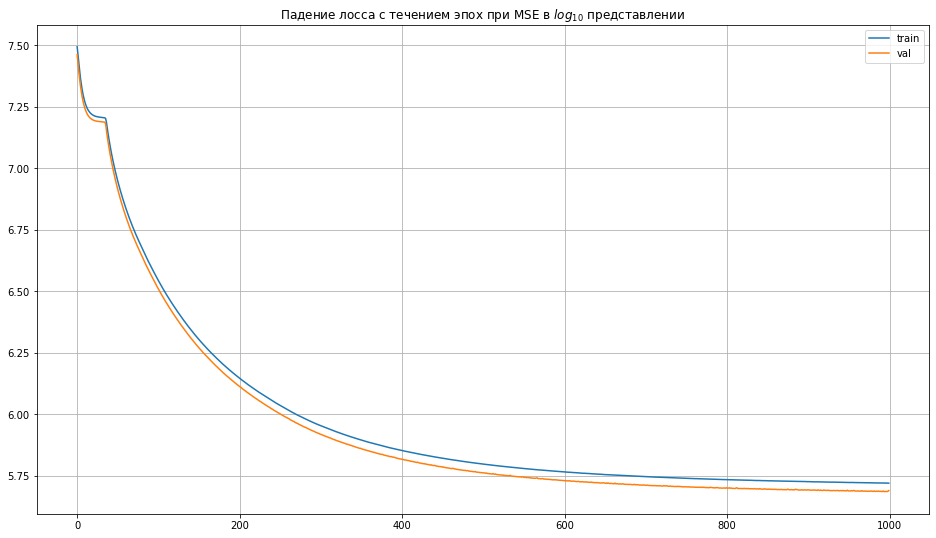

In [74]:
plt.figure(figsize=(16, 9))

plt.plot(np.log10(mymodel.epoch_train_loss), label='train')
plt.plot(np.log10(mymodel.epoch_val_loss), label='val')

plt.title("Падение лосса с течением эпох при MSE в $log_{10}$ представлении")
plt.legend()
plt.grid()
plt.show()

In [64]:
'''
Тестовый прогон, для отладки с MAE
'''

mymodelmae = MLPRegressor(
    hidden_layer_sizes=(100,), 
    max_iter=1000, 
    learning_rate=1e-2,
    loss_type = "MAE"
)
mymodelmae.fit(X_train, y_train)

In [71]:
mae_y_pred = mymodelmae.predict(X_test)
score = r2_score(mae_y_pred, y_test)
score

0.9691616447132302

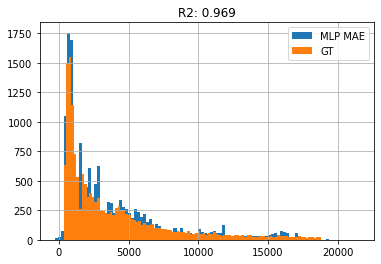

In [72]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(mae_y_pred.reshape(1, -1)[0], bins=100, label='MLP MAE')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')

plt.legend()
plt.grid()
plt.show()

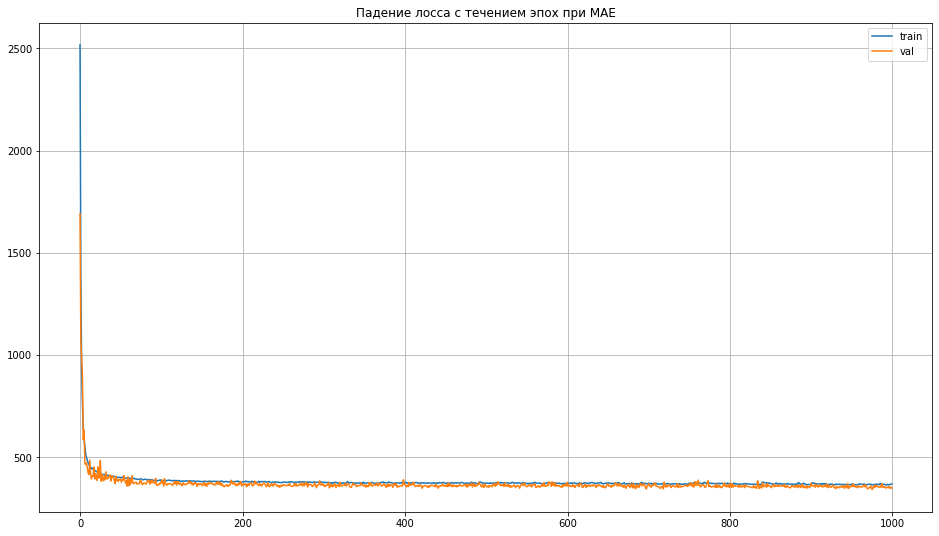

In [75]:
plt.figure(figsize=(16, 9))

plt.plot(mymodelmae.epoch_train_loss, label='train')
plt.plot(mymodelmae.epoch_val_loss, label='val')

plt.title("Падение лосса с течением эпох при MAE")
plt.legend()
plt.grid()
plt.show()

Как можно видеть, при использование в качестве лосса MAE, коэфициент детерминации становиться лучше, а также сходимость алгоритма гораздо быстрее. Также нам требуеться меньший $learning\ rate$ при обновлении весов поскольку градиенты $MAE$ намного меньше градиентов $MSE$.

### Кросс-валидация
Проверим что наши модели действительно хорошо работают, для этого проведём кроссвалидацию.

In [76]:
from sklearn.model_selection import KFold

kfold_generator = KFold(n_splits=4)

In [87]:
cnt = 1
avg_score = 0
for train_index, test_index in kfold_generator.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    my_mlp = MLPRegressor(
        hidden_layer_sizes=(100,), 
        max_iter=1000, 
        learning_rate=1e-6,
        loss_type = "MSE",
        early_stop = True,
    )

    my_mlp.fit(X_train, y_train)

    cv_y_pred = my_mlp.predict(X_test)
    cv_score = r2_score(cv_y_pred, y_test)

    avg_score += cv_score
    print(f"{cnt}) r2 : {cv_score}")
    cnt += 1

avg_score /= 4
print(f"average cv score : {avg_score}")

1) r2 : 0.7920983262292307
2) r2 : 0.8831809629805798
3) r2 : 0.8278063985596211
4) r2 : 0.6555289341779109
average cv score : 0.7896536554868356


In [92]:
cnt = 1
avg_score = 0
for train_index, test_index in kfold_generator.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    my_mlp = MLPRegressor(
        hidden_layer_sizes=(100,), 
        max_iter=100, 
        learning_rate=1e-2,
        loss_type = "MAE",
        early_stop = True,
    )

    my_mlp.fit(X_train, y_train)

    cv_y_pred = my_mlp.predict(X_test)
    cv_score = r2_score(cv_y_pred, y_test)

    avg_score += cv_score
    print(f"{cnt}) r2 : {cv_score}")
    cnt += 1

avg_score /= 4
print(f"average cv score : {avg_score}")

1) r2 : 0.7305190352893545
2) r2 : 0.744464422757487
3) r2 : 0.948968920075906
4) r2 : 0.7379586910577836
average cv score : 0.7904777672951329


# Выводы

* $MAE\ $ в качестве лосса лучше подходит для задач регресии на многослойном персептроне чем $MSE$.
* На определённых данных MLP показывает очень хорошие показатели, быстро обучаясь на выборке. Но на некоторых достаточно средние, в итоге проигрывая обычной линейной регресии.
* MLP очень легко переобучается.
* MLP требует осторожного подбора $learning\ rate$, иначе рискуем "взорваться".
* С повышением количества слоёв, сложность подбора параметров увеличивается, а градиенты, в случае $σ(xW+b)$ - как функции активации быстро затухают. 